In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
import pam

## Get trajectory

In [2]:
from clustering import Clustering,Trajectory


c = Clustering("data/laurier/laurier.sqlite","data/laurier/laurier-homography.txt")
c.get_trajectories(pixels = 1)
c.extract_features()
c.standardize_features()

clustering.py:156: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  std_data = std_data.as_matrix()


In [3]:
trajectories = [trajectory.pixel_trajectory for trajectory in c.trajectories]
std_data = pd.DataFrame([trajectory.standardized_features for trajectory in c.trajectories])

### Correlation matrix

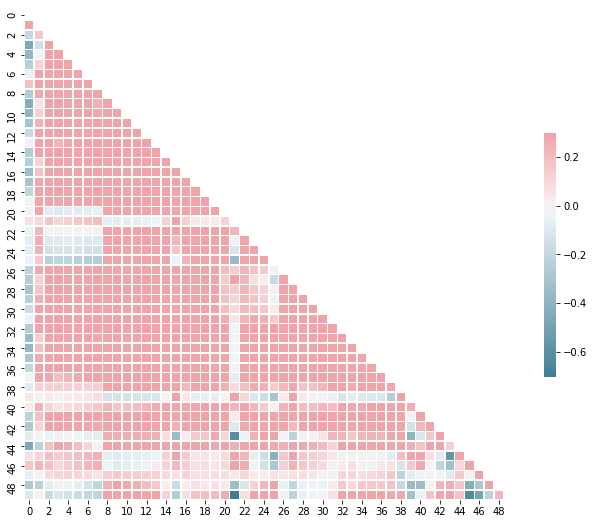

In [7]:
c.display_correlation_matrix()

### GMM

In [40]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = nb_clusters).fit(std_data)
clusters = gmm.predict(std_data)
probas = gmm.score_samples(std_data)


In [56]:
plt.hist(probas)
plt.show()

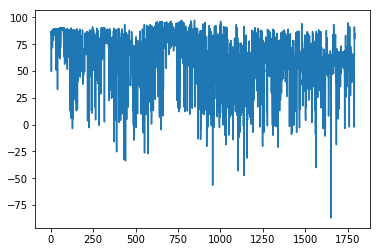

In [57]:
plt.plot(probas)
plt.show()

In [52]:
def get_outliers(threshold,probas):
    ids = []
    for i,p in enumerate(probas):
        if p < threshold:
            ids.append(i)
    print("nb outliers: " + str(len(ids)))
    return ids

In [62]:
ids = get_outliers(25, probas)

nb outliers: 238


In [63]:
plot_ids(ids,"data/laurier/laurier.jpg")

### Clustering

In [26]:
std_data.to_csv("feat.csv")

In [32]:
std_data = pd.read_csv("feat.csv")

In [6]:
from sklearn.cluster import KMeans
nb_clusters = 6 #nb pair pour l'affichage

### PAM

### Distance matrix

In [4]:
from sklearn.metrics import pairwise_distances
start = time.time()

data = std_data.as_matrix()
distance_matrix = pairwise_distances(data,metric="manhattan")


print(time.time() - start)

0.0686941146851


/home/laurent/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [10]:
start = time.time()
medoids_idx, clusters =pam.pam(distance_matrix, nb_clusters,data)

print(time.time() - start)

cost: 44085.96611299409
cost: 35673.11780590579
cost: 35416.316797876396
cost: 35386.547850251976
cost: 35386.547850251976
249.783923864


### Kmeans with medoids (self method)

In [19]:
start = time.time()
data = std_data.as_matrix()
medoids_idx, clusters =pam.kmedoid(data, nb_clusters)
print(time.time() - start)

/home/laurent/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


cost: 57036.24021367204
cost: 42699.60911907316
cost: 41643.59684436826
cost: 40099.64400405003
cost: 38769.615794938974
cost: 38250.338045646975
cost: 38224.65481881144
1.92075681686


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)

In [13]:
medoids = principalComponents[medoids_idx]
print(medoids)

[[-4.34015864  1.65503714]
 [ 8.78977872 -0.70224088]
 [ 2.55229801 -0.94633207]
 [-5.30943636 -2.24396053]
 [-1.66564396 -3.34911665]
 [ 3.81404793  1.62487936]]


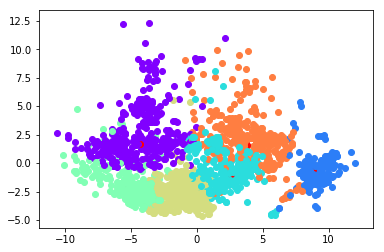

In [14]:
pam.display_pam_results_2D(principalComponents,nb_clusters,clusters, medoids, display_medoids = True)

### Plot medoids

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import cv2

def plot_ids(ids,img_name):

#img = mpimg.imread("laurier/laurier.jpg") medoids_idx:
    img = mpimg.imread(img_name)
    fig = plt.figure(figsize=(10,100))

    for j in ids:
            #img = mpimg.imread("laurier/laurier.jpg")

        pts = np.array(c.trajectories[j].pixel_trajectory , np.int32)
        pts = pts.reshape((-1,1,2))
        img = cv2.polylines(img,[pts],False,(0,0,255)) 
    plt.imshow(img)

    plt.show()
    


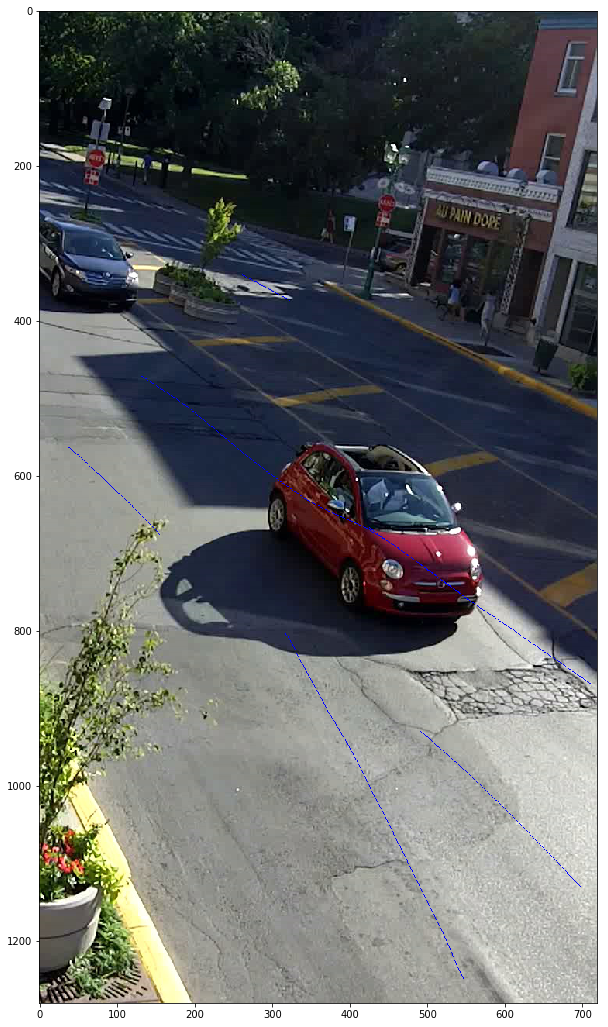

In [20]:
plot_ids(medoids_idx,"data/laurier/laurier.jpg")

# ----------------------------------------------------------------

#### K-means on standardized data

In [16]:
clusters = KMeans(n_clusters=nb_clusters, random_state=0).fit_predict(std_data)

#### DB_SCAN on standardized data

In [96]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict(std_data)

In [127]:
nb_clusters = np.max(clusters) +1
print(nb_clusters)

count = 0
for j in clusters:
    if j == -1:
        count += 1
print(count)

3
0


### Hierarchical clustering

In [145]:
from sklearn.cluster import AgglomerativeClustering

clusters = AgglomerativeClustering(n_clusters=nb_clusters).fit_predict(std_data)

## Visualize clusters on frame

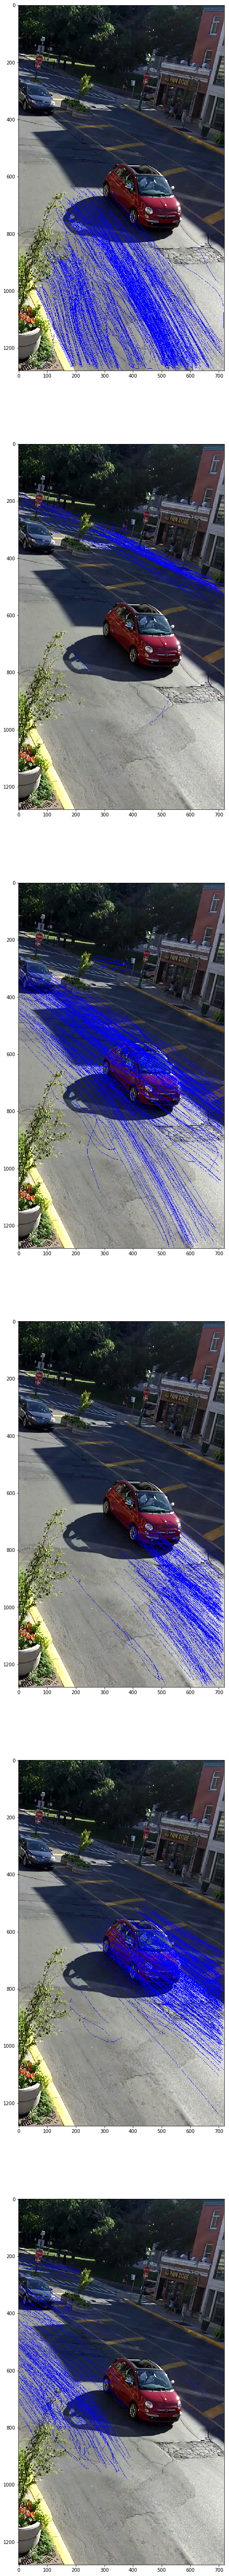

In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
import cv2

img = mpimg.imread("data/laurier/laurier.jpg")
fig = plt.figure(figsize=(10,100))

columns = 1
rows = nb_clusters

for i in range(nb_clusters):
    fig.add_subplot(rows,columns,i+1)
    img1 = copy.copy(img)
    for j,cl in enumerate(clusters):
        if cl == i:
            #img = mpimg.imread("laurier/laurier.jpg")
            
            pts = np.array(c.trajectories[j].pixel_trajectory , np.int32)
            pts = pts.reshape((-1,1,2))
            img1 = cv2.polylines(img1,[pts],False,(0,0,255)) 
    plt.imshow(img1)

plt.show()

### Visualize clustering in two dimensions with PCA

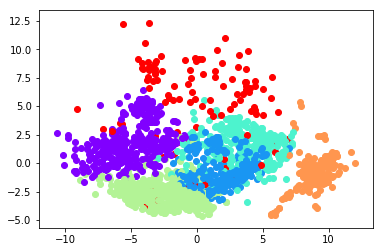

In [27]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)
ddf = pd.DataFrame(principalComponents)
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))


for i, row in ddf.iterrows():
    plt.scatter(row[0], row[1], color = colors[clusters[i]])
plt.show()

In [22]:
def display_clusters_aao(clusters,filename,pixel_trajectories,colors):
    nb_clusters = np.max(clusters)+1
    cap = cv2.VideoCapture(filename)
    ret, frame = cap.read()
    for i in range(nb_clusters):
        for j,c in enumerate(clusters):
            if c == i:
                pts = np.array(pixel_trajectories[j] , np.int32)
                pts = pts.reshape((-1,1,2))
                color = colors[clusters[j]] *255
                frame = cv2.polylines(frame,[pts],False,tuple(color[:-1]) )
    cv2.imshow('frame',frame)
    if cv2.waitKey(0) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
    #cap.release()
    #cv2.destroyAllWindows()



### Plot clustering projection 2D and on image

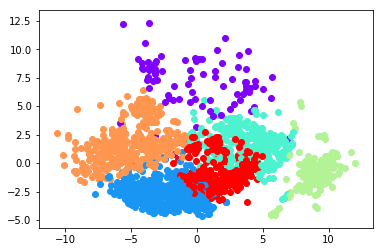

In [20]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_data)
ddf = pd.DataFrame(principalComponents)
colors = cm.rainbow(np.linspace(0, 1, nb_clusters))
for i, row in ddf.iterrows():
    #if clusters[i] != -1:
    plt.scatter(row[0], row[1], color = colors[clusters[i]])
plt.show()



import matplotlib.cm as cm
import cv2
#colors = cm.rainbow(np.linspace(0, 1, nb_clusters))
filename = "data/laurier/laurier.avi"
display_clusters_aao(clusters,filename,trajectories,colors)

In [23]:
from utils import refactor_and_plot,display_clusters_oat
display_clusters_oat(clusters,"data/laurier/laurier.avi",[trajectory.pixel_trajectory for trajectory in c.trajectories])